# Importing the Persistent Training data

In [13]:
from autogluon.tabular import TabularDataset, TabularPredictor
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from df_helpers import persistent_preprocessing

df = TabularDataset('Training.csv')
df.replace([np.inf, -np.inf], np.nan, inplace=True) 
df.dropna(inplace=True) 

df = persistent_preprocessing(df)

# cols_to_drop = ['Bwd IAT Total', 'Fwd Packets/s', 'Bwd Packets/s', 'Bwd IAT Mean', 'Fwd Act Data Pkts']
# df.drop(columns=cols_to_drop, inplace=True, axis=1)


Loaded data from: Training.csv | Columns = 84 / 84 | Rows = 259120 -> 259120


# Checking the number of data points for each Persistent attack phase

<Axes: >

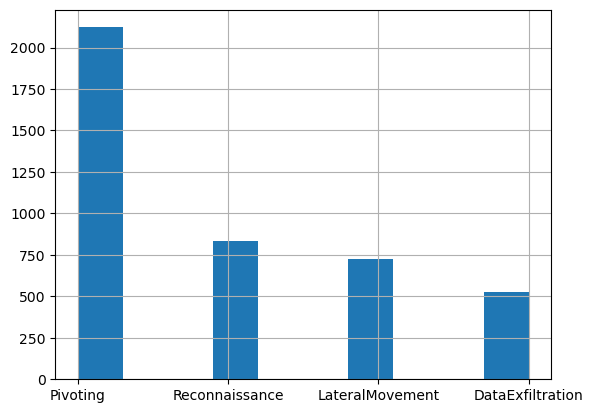

In [14]:
# normal_df = df.loc[df['Label'] == 'NormalTraffic'][:5000]
pivoting_df = df.loc[df['Label'] == 'Pivoting']
reconnaissance_df = df.loc[df['Label'] == 'Reconnaissance']
lateral_movement_df = df.loc[df['Label'] == 'LateralMovement']
data_exfiltration_df = df.loc[df['Label'] == 'DataExfiltration']
# initial_compromise_df = df.loc[df['Label'] == 'InitialCompromise']
df_weighted = pd.concat([pivoting_df, reconnaissance_df, lateral_movement_df, data_exfiltration_df])
# df_weighted = df_weighted.sample(frac=1, random_state=0)
# df_weighted.drop(['Unnamed: 0'], axis=1, inplace=True)
df_weighted['Label'].hist()


# Importing Testing data and checking Label in test data

Loaded data from: Testing.csv | Columns = 84 / 84 | Rows = 56487 -> 56487


<Axes: >

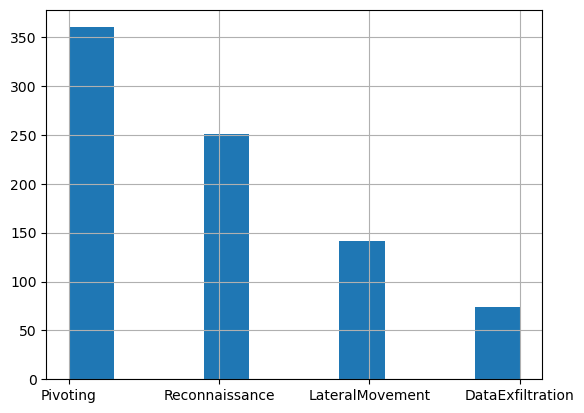

In [15]:
# test/train split
df_train = df_weighted
df_test = TabularDataset('Testing.csv')

df_test.replace([np.inf, -np.inf], np.nan, inplace=True) 
df_test.dropna(inplace=True) 

df_test = persistent_preprocessing(df_test)

# normal_df = df.loc[df['Label'] == 'NormalTraffic'][:5000]
pivoting_df = df_test.loc[df_test['Label'] == 'Pivoting']
reconnaissance_df = df_test.loc[df_test['Label'] == 'Reconnaissance']
lateral_movement_df = df_test.loc[df_test['Label'] == 'LateralMovement']
data_exfiltration_df = df_test.loc[df_test['Label'] == 'DataExfiltration']
# initial_compromise_df = df.loc[df['Label'] == 'InitialCompromise']
df_test_threats = pd.concat([pivoting_df, reconnaissance_df, lateral_movement_df, data_exfiltration_df])
df_test_threats['Label'].hist()


# Check that Train and Test set columns are matching

In [16]:
bool(set(list(df_train)).intersection(set(list(df_test_threats))))

True

# Train Model

In [17]:
# Training
predictor = TabularPredictor(label='Label', eval_metric='mcc').fit(df_train, fit_weighted_ensemble = False, presets = 'medium')



No path specified. Models will be saved in: "AutogluonModels/ag-20250409_045352"
Preset alias specified: 'medium' maps to 'medium_quality'.
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.8
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 24.3.0: Thu Jan  2 20:22:58 PST 2025; root:xnu-11215.81.4~3/RELEASE_ARM64_T8132
CPU Count:          10
Memory Avail:       2.70 GB / 16.00 GB (16.9%)
Disk Space Avail:   284.46 GB / 460.43 GB (61.8%)
Presets specified: ['medium']
Beginning AutoGluon training ...
AutoGluon will save models to "/Users/navya/Documents/Uni/Repos/autogluon/AutogluonModels/ag-20250409_045352"
Train Data Rows:    4210
Train Data Columns: 78
Label Column:       Label
AutoGluon infers your prediction problem is: 'multiclass' (because dtype of label-column == object).
	4 unique label values:  ['Pivoting', 'Reconnaissance', 'LateralMovement', 'DataEx

# Display Feature Importance for a model

In [18]:
predictor.feature_importance(df_test_threats, subsample_size=5000, num_shuffle_sets=10, model='XGBoost')

These features in provided data are not utilized by the predictor and will be ignored: ['Protocol', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Min Packet Length', 'URG Flag Count', 'Fwd Avg Bytes/Bulk', 'Fwd Avg Packets/Bulk', 'Fwd Avg Bulk Rate', 'Subflow Bwd Packets', 'Active Std', 'Active Max', 'Active Min']
Computing feature importance via permutation shuffling for 65 features using 826 rows with 10 shuffle sets...
	32.01s	= Expected runtime (3.2s per shuffle set)
	5.26s	= Actual runtime (Completed 10 of 10 shuffle sets)


,importance,stddev,p_value,n,p99_high,p99_low
Init_Win_bytes_forward,0.197989,0.012612,1.369725e-12,10,0.210950,0.185028
Total Length of Fwd Packets,0.119523,0.014775,5.130107e-10,10,0.134707,0.104340
Source Port,0.057808,0.010621,1.699547e-08,10,0.068723,0.046893
Destination Port,0.039788,0.006697,7.879914e-09,10,0.046671,0.032905
Fwd Packet Length Max,0.039314,0.007094,1.450858e-08,10,0.046605,0.032024
...,...,...,...,...,...,...
Fwd Packet Length Mean,-0.001907,0.000978,9.999174e-01,10,-0.000902,-0.002911
Packet Length Std,-0.002200,0.002188,9.944030e-01,10,0.000049,-0.004449
Total Backward Packets,-0.002329,0.001907,9.980815e-01,10,-0.000369,-0.004289
Flow IAT Max,-0.002677,0.002786,9.929696e-01,10,0.000187,-0.005540


# Display Leaderboard

In [24]:
predictor.leaderboard(df_test_threats)

,model,score_test,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,XGBoost,0.859606,0.957675,mcc,0.023018,0.005486,3.276817,0.023018,0.005486,3.276817,1,True,11
1,CatBoost,0.804655,0.951514,mcc,0.012596,0.002669,26.609808,0.012596,0.002669,26.609808,1,True,8
2,LightGBMXT,0.748742,0.957618,mcc,0.008097,0.004019,7.846015,0.008097,0.004019,7.846015,1,True,4
3,RandomForestGini,0.748126,0.948523,mcc,0.041258,0.026526,0.357195,0.041258,0.026526,0.357195,1,True,6
4,ExtraTreesGini,0.731794,0.927173,mcc,0.038993,0.026169,0.211057,0.038993,0.026169,0.211057,1,True,9
5,RandomForestEntr,0.729886,0.945515,mcc,0.024736,0.027053,0.363978,0.024736,0.027053,0.363978,1,True,7
6,ExtraTreesEntr,0.720907,0.927123,mcc,0.037469,0.027013,0.210615,0.037469,0.027013,0.210615,1,True,10
7,LightGBMLarge,0.714683,0.963652,mcc,0.029768,0.007191,19.340546,0.029768,0.007191,19.340546,1,True,13
8,LightGBM,0.689666,0.966728,mcc,0.018902,0.004886,6.231798,0.018902,0.004886,6.231798,1,True,5
9,NeuralNetFastAI,0.470895,0.827200,mcc,0.013565,0.004229,2.118610,0.013565,0.004229,2.118610,1,True,3


# Run Testing

In [25]:
y_pred = predictor.predict(df_test.drop(columns=['Label']))
y_pred.head()

0    LateralMovement
1    LateralMovement
2    LateralMovement
3    LateralMovement
4    LateralMovement
Name: Label, dtype: object

In [26]:
# 63% acc with benign data
# 87% using XGBoost and no benign data

for model in predictor.model_names():
    print(model)
    print(predictor.evaluate(df_test_threats, model=model))
    print('-----------------')

KNeighborsUnif
{'mcc': 0.0, 'accuracy': 0.30387409200968524, 'balanced_accuracy': 0.25}
-----------------
KNeighborsDist
{'mcc': 0.0, 'accuracy': 0.30387409200968524, 'balanced_accuracy': 0.25}
-----------------
NeuralNetFastAI
{'mcc': 0.4708947878371506, 'accuracy': 0.639225181598063, 'balanced_accuracy': 0.4604716254145135}
-----------------
LightGBMXT
{'mcc': 0.7487419033917245, 'accuracy': 0.8305084745762712, 'balanced_accuracy': 0.7023860773760112}
-----------------
LightGBM
{'mcc': 0.689666211642094, 'accuracy': 0.784503631961259, 'balanced_accuracy': 0.653722580128658}
-----------------
RandomForestGini
{'mcc': 0.7481259760562012, 'accuracy': 0.8305084745762712, 'balanced_accuracy': 0.7179537997775685}
-----------------
RandomForestEntr
{'mcc': 0.7298858728541896, 'accuracy': 0.8184019370460048, 'balanced_accuracy': 0.6922218177955866}
-----------------
CatBoost
{'mcc': 0.8046546787221842, 'accuracy': 0.8668280871670703, 'balanced_accuracy': 0.7901228165098217}
-----------------

# Model Export Multiclass Persistent classification

In [28]:
save_path_clone_opt = "persistent-multiclass-classifier"
# will return the path to the cloned predictor, identical to save_path_clone_opt
path_clone_opt = predictor.clone_for_deployment(path=save_path_clone_opt, model = 'XGBoost')

Cloned TabularPredictor located in '/Users/navya/Documents/Uni/Repos/autogluon/AutogluonModels/ag-20250409_045352' to 'persistent-multiclass-classifier'.
	To load the cloned predictor: predictor_clone = TabularPredictor.load(path="persistent-multiclass-classifier")
Clone: Keeping minimum set of models required to predict with model 'XGBoost'...
Deleting model KNeighborsUnif. All files under /Users/navya/Documents/Uni/Repos/autogluon/persistent-multiclass-classifier/models/KNeighborsUnif will be removed.
Deleting model KNeighborsDist. All files under /Users/navya/Documents/Uni/Repos/autogluon/persistent-multiclass-classifier/models/KNeighborsDist will be removed.
Deleting model NeuralNetFastAI. All files under /Users/navya/Documents/Uni/Repos/autogluon/persistent-multiclass-classifier/models/NeuralNetFastAI will be removed.
Deleting model LightGBMXT. All files under /Users/navya/Documents/Uni/Repos/autogluon/persistent-multiclass-classifier/models/LightGBMXT will be removed.
Deleting mo